In [ ]:
%load_ext autoreload
%autoreload 2

In [3]:
import diffprivlib as dpconda
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import pandas as pd
import sklearn.preprocessing as preprocessing
import sklearn.metrics as metrics
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import numpy as np
np.random.seed(31415)
import warnings
warnings.filterwarnings("ignore")
from tqdm import tqdm
import math
import fairlearn.metrics as mf
from multiprocessing import Pool, cpu_count

In [4]:
from train import get_classifier, train_score_clf

In [14]:
max_pools = 6 # cpu_count()-2
max_pools

6

# Model Training and Plotting Curves

In [7]:
def smooth(scalars, weight):  # Weight between 0 and 1
    last = scalars[0]  # First value in the plot (first timestep)
    smoothed = list()
    for point in scalars:
        smoothed_val = last * weight + (1 - weight) * point  # Calculate smoothed value
        smoothed.append(smoothed_val)                        # Save it
        last = smoothed_val                                  # Anchor the last smoothed value        
    return smoothed

# np.logspace(-2, 1, 4)
eps_list = np.logspace(-2, 1, 6) 

def gen_reg_model_params(X_train, y_train, X_test, y_test, cls_str, gender_attr_str, race_attr_str):
    clf = get_classifier(cls_str, diffpriv=False)
    clf.fit(X_train,y_train)
    y_pred = clf.predict(X_train)    
    acc = clf.score(X_test, y_test)    
    dp_g = mf.demographic_parity_ratio(
        y_true=np.array(y_train), 
        y_pred=y_pred, 
        sensitive_features=np.array(X_train[gender_attr_str]))
    dp_r = mf.demographic_parity_ratio(
        y_true=np.array(y_train), 
        y_pred=y_pred, 
        sensitive_features=np.array(X_train[race_attr_str]))
    eo_g = mf.equalized_odds_ratio(
        y_true=np.array(y_train), 
        y_pred=y_pred, 
        sensitive_features=np.array(X_train[gender_attr_str]))
    eo_r = mf.equalized_odds_ratio(
        y_true=np.array(y_train), 
        y_pred=y_pred, 
        sensitive_features=np.array(X_train[race_attr_str]))
    print('trained and scored baseline model')
    return (
        acc,
        dp_g,
        dp_r,
        eo_g,
        eo_r,
    )

def gen_dp_model_params(X_train, y_train, X_test, y_test, num_trials, cls_str, gender_attr_str, race_attr_str):
    
    acc_list = []
    dem_parity_list_gender = []
    dem_parity_list_race = []
    eq_opp_list_gender = []
    eq_opp_list_race = []
    acc_score = np.zeros((num_trials, len(eps_list)))
    dem_parity_score_gender = np.zeros((num_trials, len(eps_list)))
    dem_parity_score_race = np.zeros((num_trials, len(eps_list)))
    eq_opp_score_gender = np.zeros((num_trials, len(eps_list)))
    eq_opp_score_race = np.zeros((num_trials, len(eps_list)))
    
    runs = []
    for i,eps in enumerate(eps_list):
        for j in range(num_trials):    
            runs.append([j,eps,cls_str,gender_attr_str, race_attr_str,X_train,y_train,X_test,y_test])
    
    pool = Pool(max_pools) 
    mp_out = np.array(pool.starmap(train_score_clf,runs))
    pool.close()
    print('trained and scored dp models')

    return np.array(mp_out)

def avg_params(acc_score, dem_parity_score_gender, dem_parity_score_race, eq_opp_score_gender, eq_opp_score_race):
    return (
        np.mean(acc_score, axis=0),
        pd.Series(np.mean(dem_parity_score_gender, axis=0)).interpolate().fillna(method='bfill'),
        pd.Series(np.mean(dem_parity_score_race, axis=0)).interpolate().fillna(method='bfill'),
        pd.Series(np.mean(eq_opp_score_gender, axis=0)).interpolate().fillna(method='bfill'),
        pd.Series(np.mean(eq_opp_score_race, axis=0)).interpolate().fillna(method='bfill'),
    
    )

def plot_params(pp_l, dp_pp_l, cls_str, smoothing):
    
    acc, dp_g, dp_r, eo_g, eo_r = pp_l
    acc_list, dem_parity_list_gender, dem_parity_list_race, eq_opp_list_gender, eq_opp_list_race = dp_pp_l
    
    fig, ax = plt.subplots()
    plt.suptitle(cls_str + ' Classifier Accuracy and Fairness Metrics vs Epsilon - FM dataset') 
    plt.title('Dashed and Solid Lines for Standard and Private Classifiers', fontsize='small')
    plt.axhline(acc, color='r', linestyle='--')
    plt.axhline(dp_g, color='g', linestyle='--')
    plt.axhline(dp_r, color='b', linestyle='--')
    plt.axhline(eo_g, color='m', linestyle='--')
    plt.axhline(eo_r, color='y', linestyle='--')   
    
    plt.semilogx(eps_list, smooth(acc_list,smoothing), label='Accuracy', color='r')
    plt.semilogx(eps_list, smooth(dem_parity_list_gender,smoothing), label='Dem Par Gender', color='g')
    plt.semilogx(eps_list, smooth(dem_parity_list_race,smoothing), label='Dem Par Race', color='b')
    plt.semilogx(eps_list, smooth(eq_opp_list_gender,smoothing), label='Eq Opp Gender', color='m')
    plt.semilogx(eps_list, smooth(eq_opp_list_race,smoothing), label='Eq Opp Race', color='y')
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.ylim(0,1)
    plt.xlabel('Epsilon')
    plt.ylabel('Accuracy / Fairness')
    
    fig.patch.set_facecolor('white')    
    plt.savefig('plots/'+cls_str+'.png', dpi=150, bbox_inches='tight',transparent=False)
    plt.show()
    
def make_plot_data(dp_pp,eps_list):
    a1 = dp_pp.reshape(len(eps_list),int(dp_pp.shape[0]/len(eps_list)),dp_pp.shape[1])
    return np.array([ pd.Series(np.mean(e, axis=0)).interpolate().fillna(method='bfill') for e in a1 ]).T

def plot_data_from_files(f_list):
    dp_pp_list = [make_plot_data(np.loadtxt(f),eps_list) for f in f_list]
    return [ np.mean([dp_pp[i] for dp_pp in dp_pp_list],axis=0) for i in range(5)]

# Load Data

In [8]:
save_data_loc = '../data/fm2020/'
X_train = pd.read_pickle(save_data_loc+'X_train.gz')
y_train = pd.read_pickle(save_data_loc+'y_train.gz')
X_test = pd.read_pickle(save_data_loc+'X_test.gz')
y_test = pd.read_pickle(save_data_loc+'y_test.gz')

In [9]:
'{:,}'.format(len(X_train)), '{:,}'.format(len(X_test))

('2,599,799', '649,950')

In [33]:
### Trim data for testing

# tr_cut = np.random.random_integers(0, len(X_train)-1, int(2.6e5))
# test_cut = np.random.random_integers(0, len(X_test)-1, int(1e5))

# X_train.index = np.arange(0,len(X_train))
# y_train.index = np.arange(0,len(X_train))
# X_test.index = np.arange(0,len(X_test))
# y_test.index = np.arange(0,len(X_test))

# X_train = X_train.iloc[tr_cut] 
# y_train = y_train.iloc[tr_cut]
# X_test = X_test.iloc[test_cut]
# y_test = y_test.iloc[test_cut]

# '{:,}'.format(len(X_train)), '{:,}'.format(len(X_test))

('260,000', '100,000')

In [10]:
trial_block_size = 5

In [11]:
dp_pp_1 = gen_dp_model_params(
    X_train, y_train, X_test, y_test,
    trial_block_size, 'NB', 'gender_m', 'r_white_non_hisp')
i = 1
np.savetxt('./res/dpnb_full_{}.txt'.format(i),np.array(dp_pp_1))

trained and scored dp models


In [15]:
dp_pp_2 = gen_dp_model_params(
    X_train, y_train, X_test, y_test,
    trial_block_size, 'NB', 'gender_m', 'r_white_non_hisp')
i = 2
np.savetxt('./res/dpnb_full_{}.txt'.format(i),np.array(dp_pp_2))

trained and scored dp models


In [16]:
dp_pp_3 = gen_dp_model_params(
    X_train, y_train, X_test, y_test, 
    trial_block_size, 'NB', 'gender_m', 'r_white_non_hisp')
i = 3
np.savetxt('./res/dpnb_full_{}.txt'.format(i),np.array(dp_pp_3))

trained and scored dp models


In [17]:
dp_pp_4 = gen_dp_model_params(
    X_train, y_train, X_test, y_test,
    trial_block_size, 'NB', 'gender_m', 'r_white_non_hisp')
i = 4
np.savetxt('./res/dpnb_full_{}.txt'.format(i),np.array(dp_pp_4))

trained and scored dp models


In [18]:
dp_pp_5 = gen_dp_model_params(
    X_train, y_train, X_test, y_test,
    trial_block_size, 'NB', 'gender_m', 'r_white_non_hisp')
i = 5
np.savetxt('./res/dpnb_full_{}.txt'.format(i),np.array(dp_pp_5))

trained and scored dp models


In [19]:
pp_dpnb = plot_data_from_files([
    './res/dpnb_full_1.txt',
    './res/dpnb_full_2.txt',
    './res/dpnb_full_3.txt',
    './res/dpnb_full_4.txt',
    './res/dpnb_full_5.txt']
)

In [20]:
pp_nb = gen_reg_model_params(
    X_train, y_train, X_test, y_test,
    'NB', 'gender_m', 'r_white_non_hisp')

trained and scored baseline model


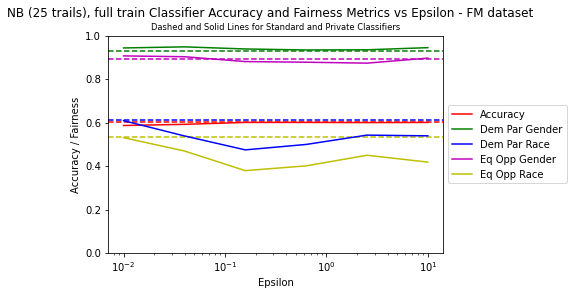

In [34]:
plot_params(
    pp_nb,
    pp_dpnb,
    'NB (25 trails), full train',0.3)

In [22]:
dp_pp_1 = gen_dp_model_params(
    X_train, y_train, X_test, y_test,
    trial_block_size, 'LR', 'gender_m', 'r_white_non_hisp')
i = 1
np.savetxt('./res/dplr_full_{}.txt'.format(i),np.array(dp_pp_1))

trained and scored dp models


In [23]:
dp_pp_2 = gen_dp_model_params(
    X_train, y_train, X_test, y_test,
    trial_block_size, 'LR', 'gender_m', 'r_white_non_hisp')
i = 2
np.savetxt('./res/dplr_full_{}.txt'.format(i),np.array(dp_pp_2))

trained and scored dp models


In [24]:
dp_pp_3 = gen_dp_model_params(
    X_train, y_train, X_test, y_test, 
    trial_block_size, 'LR', 'gender_m', 'r_white_non_hisp')
i = 3
np.savetxt('./res/dplr_full_{}.txt'.format(i),np.array(dp_pp_3))

trained and scored dp models


In [25]:
dp_pp_4 = gen_dp_model_params(
    X_train, y_train, X_test, y_test,
    trial_block_size, 'LR', 'gender_m', 'r_white_non_hisp')
i = 4
np.savetxt('./res/dplr_full_{}.txt'.format(i),np.array(dp_pp_4))

trained and scored dp models


In [26]:
dp_pp_5 = gen_dp_model_params(
    X_train, y_train, X_test, y_test,
    trial_block_size, 'LR', 'gender_m', 'r_white_non_hisp')
i = 5
np.savetxt('./res/dplr_full_{}.txt'.format(i),np.array(dp_pp_5))

trained and scored dp models


In [27]:
pp_lr = gen_reg_model_params(
    X_train, y_train, X_test, y_test,
    'LR', 'gender_m', 'r_white_non_hisp')

trained and scored baseline model


In [28]:
pp_dplr = plot_data_from_files([
    './res/dplr_full_1.txt',
    './res/dplr_full_2.txt',
    './res/dplr_full_3.txt',
    './res/dplr_full_4.txt',
    './res/dplr_full_5.txt']
)

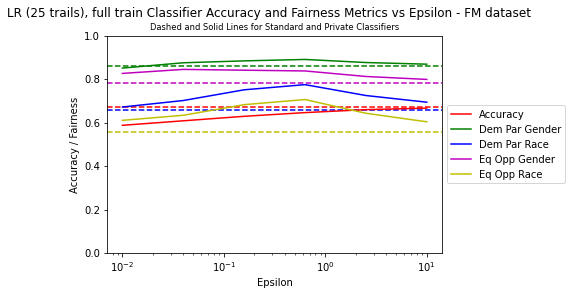

In [29]:
plot_params(
    pp_lr,
    pp_dplr,
    'LR (25 trails), full train',0.5)